In [11]:
import voxelwise_tutorials
from himalaya.ridge import RidgeCV
import numpy as np
from pathlib import Path
from AOTaccess.stimulus_info_access import StimuliInfoAccess
from AOTaccess.glmsingle_access import GLMSingleAccess
from AOTanalysis.bandedRR.construct_features import (
    construct_features_motion_energy_from_subses,
    construct_features_sbert_embeddings_from_subses,
)
from AOTanalysis.bandedRR.construct_target import (
    construct_target_data_from_session_flatten_masked
)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from himalaya.backend import set_backend


from himalaya.kernel_ridge import MultipleKernelRidgeCV
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.kernel_ridge import Kernelizer
from sklearn import set_config
from himalaya.kernel_ridge import ColumnKernelizer
from voxelwise_tutorials.utils import explainable_variance
from AOTanalysis.bandedRR.utils import split_single_array
from AOTglmsingle.glmoutput_save_nifti import get_affine_matrix
from AOTanalysis.bandedRR.utils import reshape_from_flatten_masked_to_wholebrain
from himalaya.scoring import r2_score

import os


import joblib
import nibabel as nib

import voxelwise_tutorials
from himalaya.ridge import RidgeCV
import numpy as np
from pathlib import Path
from AOTaccess.stimulus_info_access import StimuliInfoAccess
from AOTaccess.glmsingle_access import GLMSingleAccess
from AOTaccess.expdesign_access import ExpDesignAccess
from AOTanalysis.bandedRR.construct_features import (
    construct_features_motion_energy,
    construct_features_sbert_embeddings,
    construct_features_sbert_embeddings_PCA,
    construct_features_motion_energy_from_subses,
    construct_features_sbert_embeddings_from_subses,
)
from AOTanalysis.bandedRR.construct_target import (
    construct_target_data_from_session_flatten_masked,
)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from himalaya.backend import set_backend


from himalaya.kernel_ridge import MultipleKernelRidgeCV
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.kernel_ridge import Kernelizer
from sklearn import set_config
from himalaya.kernel_ridge import ColumnKernelizer
from voxelwise_tutorials.utils import explainable_variance
from AOTanalysis.bandedRR.utils import split_single_array
from AOTglmsingle.glmoutput_save_nifti import get_affine_matrix
from AOTanalysis.bandedRR.utils import reshape_from_flatten_masked_to_wholebrain
from himalaya.scoring import r2_score

import os

import joblib
import nibabel as nib

def data_construct(
    sub,
    ses,
    feature,
    Ycentered=True,
    Xcentered=False,
):
    expdesign_access = ExpDesignAccess()
    video_indexes = expdesign_access.get_session_video_indexes(sub, ses)
    video_betas = construct_target_data_from_session_flatten_masked(
        sub, ses, centered=Ycentered
    )
    if video_betas.shape[0] != len(video_indexes):
        # cut
        video_betas = video_betas[: len(video_indexes)]
    print(f"Shape of video betas: {video_betas.shape}")
    if feature == "motion":
        X = construct_features_motion_energy_from_subses(sub, ses, centered=Xcentered)
    elif feature == "semantic":
        X = construct_features_sbert_embeddings_from_subses(
            sub, ses, centered=Xcentered
        )
    else:
        raise ValueError("feature must be 'motion' or 'semantic'")
    print(f"Shape of X: {X.shape}")

    y = video_betas
    print(f"Shape of y: {y.shape}")

    # split the data
    Xtrain, Xtest = split_single_array(X, n_splits=2)
    ytrain, ytest = split_single_array(y, n_splits=2)
    print(f"Shape of Xtrain: {Xtrain.shape}")
    print(f"Shape of Xtest: {Xtest.shape}")
    print(f"Shape of ytrain: {ytrain.shape}")
    print(f"Shape of ytest: {ytest.shape}")

    if np.isnan(y).any() or np.isinf(y).any():
        y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)

    return Xtrain, ytrain, Xtest, ytest


sub = 3
train_ses = 1
Xcentered = True
Ycentered = True
Xstd = False
direction = "fw"
feature = "semantic"

test_time_normalization = True

model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_session_testinside/model_sub{sub}_feature_{feature}_trainses_1_Xcentered_{Xcentered}_Ycentered_{Ycentered}_Xstd_{Xstd}_testinside.joblib"
R2_file = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_session_testinside/R2_score_single_sub{sub}_feature_{feature}_trainses_1_Xcentered_{Xcentered}_Ycentered_{Ycentered}_Xstd_{Xstd}_testinside.nii.gz"

model = joblib.load(model_path)

glmsingle_access = GLMSingleAccess()
stimuli_info_access = StimuliInfoAccess()

Xtrain, ytrain, Xtest, ytest = data_construct(
    sub=sub,
    ses=train_ses,
    feature=feature,
    Ycentered=Ycentered,
    Xcentered=Xcentered,
)

print(f"Shape of test_X: {Xtest.shape}")
print(f"Shape of test_y: {ytest.shape}")


def mask_construct(R2_file, threshold=0.01):
    R2 = nib.load(R2_file).get_fdata()
    mask = np.zeros_like(R2)
    mask[R2 > threshold] = 1
    return mask


print(f"Shape of test_video_betas: {ytest.shape}")  # (360,641846)
len_test = ytest.shape[0]
list_of_test_video_betas_glm = [ytest[i] for i in range(len_test)]
list_of_test_video_betas_glm_wholebrain = [
    reshape_from_flatten_masked_to_wholebrain(list_of_test_video_betas_glm[i], sub=sub)
    for i in range(len_test)
]
print(
    f"len of list_of_test_video_betas_wholebrain: {len(list_of_test_video_betas_glm_wholebrain)}"
)
print(
    f"Shape of list_of_test_video_betas_wholebrain[0]: {list_of_test_video_betas_glm_wholebrain[0].shape}"
)

print(f"Shape of test_X: {Xtest.shape}")

Loaded expdesign from /tank/zhangs/AOT_code_repos/arrow_of_time_experiment/aot/data/experiment/settings/main/experiment_settings_sub_03_ses_01_run_01.yml
Loaded expdesign from /tank/zhangs/AOT_code_repos/arrow_of_time_experiment/aot/data/experiment/settings/main/experiment_settings_sub_03_ses_01_run_02.yml
Loaded expdesign from /tank/zhangs/AOT_code_repos/arrow_of_time_experiment/aot/data/experiment/settings/main/experiment_settings_sub_03_ses_01_run_03.yml
Loaded expdesign from /tank/zhangs/AOT_code_repos/arrow_of_time_experiment/aot/data/experiment/settings/main/experiment_settings_sub_03_ses_01_run_04.yml
Loaded expdesign from /tank/zhangs/AOT_code_repos/arrow_of_time_experiment/aot/data/experiment/settings/main/experiment_settings_sub_03_ses_01_run_05.yml
Loaded expdesign from /tank/zhangs/AOT_code_repos/arrow_of_time_experiment/aot/data/experiment/settings/main/experiment_settings_sub_03_ses_01_run_06.yml
Loaded expdesign from /tank/zhangs/AOT_code_repos/arrow_of_time_experiment/a

In [12]:
print(f"Shape of test_X: {Xtest.shape}")
print(
    f"len of list_of_test_video_betas_glm_wholebrain: {len(list_of_test_video_betas_glm_wholebrain)}"
)
print(
    f"Shape of list_of_test_video_betas_glm_wholebrain[0]: {list_of_test_video_betas_glm_wholebrain[0].shape}"
)

Shape of test_X: (360, 768)
len of list_of_test_video_betas_glm_wholebrain: 360
Shape of list_of_test_video_betas_glm_wholebrain[0]: (84, 95, 106)


In [13]:
from himalaya.backend import set_backend

set_backend("torch_cuda", on_error="warn")
#set_backend("numpy")
test_X = np.array(Xtest)
model_predictions = model.predict(test_X)

print(f"Shape of model_predictions: {model_predictions.shape}")

Shape of model_predictions: torch.Size([360, 344817])


In [14]:
model_predictions = np.array(model_predictions)
print(f"Shape of model_predictions: {model_predictions.shape}")
len_test = model_predictions.shape[0]
list_of_model_predictions_wholebrain = [
    reshape_from_flatten_masked_to_wholebrain(model_predictions[i], sub)
    for i in range(len_test)
]
print(
    f"len of list_of_model_predictions_wholebrain: {len(list_of_model_predictions_wholebrain)}"
)


Shape of model_predictions: (360, 344817)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp_newpreproc/sub-003_ses-01_T1W_nordicstc_1.7mm/TYPED_FITHRF_GLMDENOISE_RR/R2.nii.gz
Shape of R2: (84, 95, 106)
Shape of R2 mask: (84, 95, 106)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp_newpreproc/sub-003_ses-01_T1W_nordicstc_1.7mm/TYPED_FITHRF_GLMDENOISE_RR/R2.nii.gz
Shape of R2: (84, 95, 106)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp_newpreproc/sub-003_ses-01_T1W_nordicstc_1.7mm/TYPED_FITHRF_GLMDENOISE_RR/R2.nii.gz
Shape of R2: (84, 95, 106)
Shape of R2 mask: (84, 95, 106)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp_newpreproc/sub-003_ses-01_T1W_nordicstc_1.7mm/TYPED_FITHRF_GLMDENOISE_RR/R2.nii.gz
Shape of R2: (84, 95, 106)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp_newpreproc/sub-003_ses-01_T1W_nordicstc_1.7mm/TYPED_FITHRF_GLMDENOISE_RR/R2.nii.gz
S

In [15]:
def mask_and_flatten_list_of_data(list_of_data, mask):
    masked_data = [data[mask == 1] for data in list_of_data]
    flattened_masked_data = [data.flatten() for data in masked_data]
    return flattened_masked_data



In [16]:
prediction_R2_mask = mask_construct(R2_file)
print(f"Shape of prediction_R2_mask: {prediction_R2_mask.shape}")


flatten_and_masked_model_predictions = mask_and_flatten_list_of_data(
    list_of_model_predictions_wholebrain, prediction_R2_mask
)

flatten_and_masked_test_video_betas_glm = mask_and_flatten_list_of_data(
    list_of_test_video_betas_glm_wholebrain, prediction_R2_mask
)

print(
    f"Shape of flatten_and_masked_model_predictions: {flatten_and_masked_model_predictions[0].shape}"
)

print(
    f"Shape of flatten_and_masked_test_video_betas_glm: {flatten_and_masked_test_video_betas_glm[0].shape}"
)   


# L2 normalization both model_predictions and test_video_betas
from sklearn.preprocessing import Normalizer

if test_time_normalization:
    normalizer = Normalizer()
    normalizer.fit(flatten_and_masked_model_predictions)
    flatten_and_masked_model_predictions = normalizer.transform(
        flatten_and_masked_model_predictions
    )
    flatten_and_masked_test_video_betas_glm = normalizer.transform(
        flatten_and_masked_test_video_betas_glm
    )

# pick the first n data
# n = 500
# flatten_and_masked_model_predictions = flatten_and_masked_model_predictions[:n]
# flatten_and_masked_test_video_betas_glm = flatten_and_masked_test_video_betas_glm[:n]

Shape of prediction_R2_mask: (84, 95, 106)
Shape of flatten_and_masked_model_predictions: (19564,)
Shape of flatten_and_masked_test_video_betas_glm: (19564,)


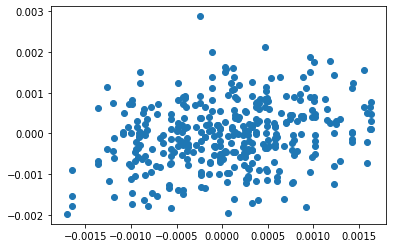

In [17]:
import seaborn as sns
# sns.heatmap(flatten_and_masked_model_predictions)
import matplotlib.pyplot as plt
plt.plot(
    np.array(flatten_and_masked_model_predictions).mean(1),
    np.array(flatten_and_masked_test_video_betas_glm).mean(1),
    "o",
)

In [18]:
# for each prediction, get the most similar betas
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_distances


def get_most_similar_beta(prediction, betas,metric_func=cosine_similarity):
    similarity = metric_func([prediction], betas)
    most_similar_index = np.argmax(similarity)
    return most_similar_index


most_similar_betas = [get_most_similar_beta(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas: {len(most_similar_betas)}")
print(f"most_similar_betas: {most_similar_betas}")


# pearsonr from sklearn


most_similar_betas_euclidean = [get_most_similar_beta(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm,metric_func=euclidean_distances) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas_euclidean: {len(most_similar_betas_euclidean)}")
print(f"most_similar_betas_euclidean: {most_similar_betas_euclidean}")

most_similar_betas_manhattan = [get_most_similar_beta(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm,metric_func=manhattan_distances) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas_manhattan: {len(most_similar_betas_manhattan)}")
print(f"most_similar_betas_manhattan: {most_similar_betas_manhattan}")

most_similar_betas_cosine = [get_most_similar_beta(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm,metric_func=cosine_distances) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas_cosine: {len(most_similar_betas_cosine)}")
print(f"most_similar_betas_cosine: {most_similar_betas_cosine}")




Shape of most_similar_betas: 360
most_similar_betas: [0, 136, 14, 2, 55, 293, 2, 41, 194, 206, 319, 194, 333, 327, 59, 329, 327, 17, 17, 59, 95, 21, 55, 118, 329, 329, 53, 1, 149, 35, 331, 120, 206, 196, 359, 327, 94, 206, 14, 137, 136, 7, 33, 206, 53, 1, 93, 327, 14, 55, 206, 42, 206, 94, 206, 13, 326, 136, 14, 259, 332, 61, 329, 104, 319, 21, 2, 206, 310, 333, 264, 13, 206, 196, 14, 55, 14, 196, 94, 128, 137, 206, 21, 35, 25, 0, 287, 52, 326, 14, 7, 194, 137, 59, 94, 330, 194, 94, 330, 218, 118, 178, 206, 22, 19, 137, 16, 206, 93, 26, 196, 326, 137, 94, 19, 7, 94, 319, 297, 197, 330, 26, 19, 206, 14, 13, 4, 35, 128, 42, 218, 119, 55, 146, 13, 28, 13, 137, 17, 171, 94, 129, 16, 55, 327, 136, 327, 196, 118, 197, 297, 206, 206, 94, 286, 59, 319, 194, 128, 59, 51, 197, 14, 129, 137, 194, 206, 128, 133, 16, 105, 128, 137, 21, 2, 129, 319, 4, 128, 59, 128, 327, 14, 13, 194, 295, 277, 129, 297, 327, 137, 55, 310, 196, 21, 55, 359, 33, 59, 4, 194, 129, 206, 205, 137, 205, 277, 137, 57, 332, 

In [19]:
from scipy.stats import pearsonr


def scores_for_a_prediction(prediction,betas):
    scores = [pearsonr(prediction,beta)[0] for beta in betas]
    return scores


def get_most_similar_beta_corr(prediction, betas):
    scores = scores_for_a_prediction(prediction,betas)
    most_similar_index = np.argmax(scores)
    return most_similar_index

most_similar_betas_corr = [get_most_similar_beta_corr(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas_corr: {len(most_similar_betas_corr)}")
print(f"most_similar_betas_corr: {most_similar_betas_corr}")

Shape of most_similar_betas_corr: 360
most_similar_betas_corr: [0, 136, 14, 2, 55, 59, 2, 41, 194, 206, 319, 194, 64, 327, 59, 329, 327, 17, 17, 59, 95, 21, 55, 39, 329, 329, 53, 1, 149, 35, 331, 30, 206, 196, 359, 327, 94, 206, 14, 137, 136, 7, 33, 206, 53, 1, 93, 327, 14, 55, 206, 42, 206, 94, 206, 13, 326, 136, 14, 259, 332, 61, 329, 104, 319, 21, 2, 206, 310, 64, 60, 13, 206, 196, 14, 55, 14, 196, 94, 128, 137, 206, 21, 35, 25, 0, 287, 52, 326, 14, 7, 194, 137, 59, 94, 330, 194, 94, 330, 218, 118, 178, 206, 22, 19, 137, 16, 206, 93, 26, 196, 326, 137, 94, 19, 7, 94, 319, 297, 197, 330, 26, 19, 206, 14, 13, 4, 35, 128, 42, 218, 119, 55, 146, 13, 28, 13, 137, 17, 171, 94, 129, 16, 55, 327, 136, 125, 196, 39, 328, 297, 206, 206, 94, 286, 59, 319, 194, 128, 59, 51, 197, 14, 120, 137, 194, 206, 128, 133, 16, 105, 128, 137, 21, 2, 120, 319, 4, 128, 59, 128, 327, 14, 13, 194, 295, 277, 129, 297, 327, 137, 55, 310, 196, 21, 55, 359, 33, 59, 4, 194, 129, 206, 205, 137, 205, 277, 137, 57, 33

Shape of similarity_matrix: (360, 360)


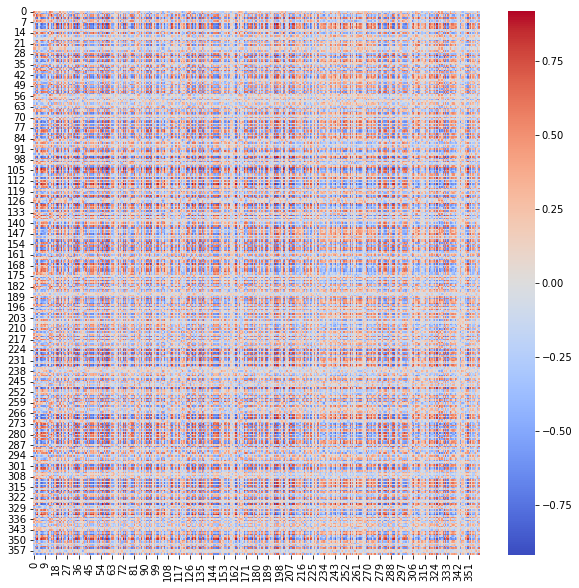

In [20]:
# draw a picture to show the similarity matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

similarity_matrix = [scores_for_a_prediction(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm) for i in range(len(flatten_and_masked_model_predictions))]

similarity_matrix = similarity_matrix
similarity_matrix = np.array(similarity_matrix)



print(f"Shape of similarity_matrix: {similarity_matrix.shape}")
plt.figure(figsize=(10, 10))
sns.heatmap(similarity_matrix, cmap="coolwarm", center=0)
plt.show()